Essentials imports.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

from tqdm import tqdm
import random as rn
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

from skimage import feature, color, data
from sklearn.preprocessing import LabelEncoder

Taking a glance at the data.

In [2]:
labels = pd.read_csv("datasets/bee_data.csv", index_col=0)

labels.head()

,date,time,location,zip code,subspecies,health,pollen_carrying,caste
file,,,,,,,,
041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


Create a function to convert image in to numpy array.

In [3]:
def image_to_np(image_id):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    root="datasets/bee_imgs/"
    filename = image_id
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

Plotting the image.

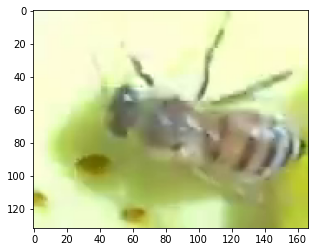

In [4]:
plt.imshow(image_to_np("041_073.png"))
plt.show()


Save the subspecies labels.

In [5]:
subspecies = labels.subspecies.unique().tolist()

Remove file as the index using reset_index() method.

In [6]:
labels = labels.reset_index()

In [7]:
labels.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


Create a function to display image refrence to its index and return the subspecies of the bee nad the file name.

In [8]:
def show_image(index):
    """
    Displays an image from the dataset with respect to the given index and returns the subspecies|.
    """
    file_name = labels[labels.index==index].file.values[0]
    subspecies = labels[labels.index==index].subspecies.values[0]
    img = image_to_np(file_name)
    plt.imshow(img)
    plt.show()
    return file_name, subspecies
    

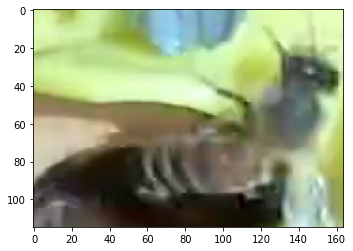

('041_066.png', '-1')

In [9]:
show_image(0)

Generate the hog features.

In [10]:
def hog_data_extractor(img_name):
    root="datasets/bee_imgs/"
    img_path = os.path.join(root, img_name)
    img_data = cv2.imread(img_path)
    img_data = cv2.resize(img_data, (150, 150))
    hog_data = feature.hog(img_data)/255.0
    return hog_data

In [11]:
hog_data_extractor("041_073.png")

array([1.03128687e-03, 3.53268733e-04, 0.00000000e+00, ...,
       4.36513914e-05, 4.01787839e-05, 2.50650593e-04])

Save file_name and subspecies to array.

In [12]:

file_name_all = labels.file.values
subspecies_all = labels.subspecies.values

In [13]:
print(subspecies_all)

['-1' '-1' '-1' ... '-1' '-1' '-1']


Store the hog features in to X_train and X_test.

In [14]:
X_train = []
X_test = []
label_train = []
label_test = []

train_percent = 0.8
data_length = len(file_name_all)
train_index = int(data_length*train_percent)

In [15]:

for i in range(train_index):
    try:
        hog_data = hog_data_extractor(file_name_all[i])
        X_train.append(hog_data)
        label_train.append(subspecies_all[i])
    except:
        print(file_name_all[i], subspecies_all[i])
        print("Error")

In [16]:
for i in range(train_index, data_length):
    try:
        hog_data = hog_data_extractor(file_name_all[i])
        X_test.append(hog_data)
        label_test.append(subspecies_all[i])
    except:
        print(file_name_all[i], subspecies_all[i])
        print("Error")

Use label encoder to encode the subspecies.

In [17]:
le = LabelEncoder()
y_train = le.fit_transform(label_train)
y_test = le.fit_transform(label_test)

Create a Linear SVM classifier and train it.

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC


In [19]:
lsvc = LinearSVC(random_state=0, tol=1e-5)
lsvc.fit(X_train, y_train)
print("Coef", lsvc.coef_)
print("Intercept", lsvc.intercept_)

Coef [[ 0.02811001  0.09825899  0.00444417 ...  0.00617299  0.01472954
  -0.00031227]
 [-0.08739696 -0.10628165 -0.06286554 ... -0.00516496  0.01854791
   0.05117653]
 [ 0.06358187 -0.00267521  0.02393856 ... -0.05592517 -0.09279016
  -0.03365257]
 [-0.07693856 -0.03609017  0.00804212 ...  0.09394532  0.06711836
   0.00457704]
 [ 0.07136858  0.04653765  0.0259398  ... -0.03962858 -0.00809859
  -0.02227656]]
Intercept [-0.87466912 -0.65542066  0.23586739 -0.85779872 -0.84288143]


Score and Cross Value result of the model.

In [20]:
# filter all the warnings
import warnings
warnings.filterwarnings("ignore")

# 10-fold cross validation
lsvc_score = lsvc.score(X_test, y_test)
print("Score", lsvc_score)
kfold = KFold(n_splits=10, random_state=9, shuffle=True)
cv_results = cross_val_score(lsvc, X_train, y_train, cv=kfold, scoring='accuracy')
print(cv_results)

Score 0.4289855072463768
[0.63768116 0.62801932 0.647343   0.5942029  0.60869565 0.65458937
 0.57246377 0.60532688 0.60774818 0.64164649]


In [21]:
print(cv_results.mean(), cv_results.std())

0.6197716718718929 0.024914706008686338


In [23]:
def scene_predict(img_name):
    root="datasets/bee_imgs/"
    img_path = os.path.join(root, img_name)
    image = cv2.imread(img_path)
    ip_image = Image.open(img_path)
    image = cv2.resize(image, (150, 150))
    prd_image_data = hog_data_extractor(img_name)
    subspecies_predict = lsvc.predict(prd_image_data.reshape(1, -1))[0]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
    ax[0].imshow(ip_image)
    ax[0].set_title("Input Image")
    
    ax[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Predicted Image:" + subspecies[subspecies_predict])

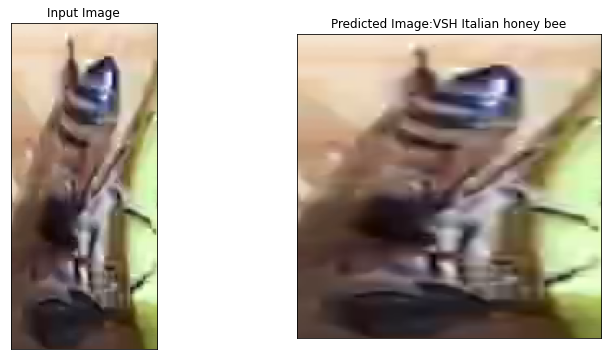

In [27]:
ip_img_files = ["041_072.png"]
scene_predicted = scene_predict(ip_img_files[0])